# *CePNEM analysis notebook v1.0.1*

This notebook is a guide to interpreting CePNEM model fits on either NeuroPAL or other GCaMP data. It can compute a variety of statistics based on the CePNEM fits, including encoding categorization of neurons, encoding change, variability, and more. After running this notebook, check out the companion notebooks `CePNEM-plots.ipynb` for interactive plotting of the data, `CePNEM-UMAP.ipynb` to compute and visualize UMAP dimensionality reduction, and `CePNEM-auxiliary.ipynb` for other miscallaneous code, such as computing model validation statistics and other controls and small analyses.

This notebook is intended to be used after you have already fit the CePNEM model on all of your data; see `CePNEM-fit.ipynb` for an example notebook on how to do this.

Note that this notebook will use a lot of memory (1-3GB per dataset). Once you have run it once, you can save the output files to small `JLD2` files and load them in this or other notebooks (these files will use ~15MB per dataset).

For more information, see https://flavell-lab.github.io/CePNEMAnalysis.jl and https://flavell-lab.github.io/CePNEM.jl

# Initialization

This section imports the necessary packages, and initializes the plotting settings.

Expected runtime: 1-5 minutes

In [1]:
using CePNEMAnalysis, StatsBase, Plots, Plots.PlotMeasures, ProgressMeter, CePNEM, MultivariateStats,
        ColorVectorSpace, MultipleTesting, HDF5, JLD2, Gen, ANTSUNData, FlavellConstants, UMAP, ImageShow, LinearAlgebra,
        ImageCore, Clustering, Images, GLMNet, Combinatorics, Distributions, FlavellBase, PyPlot, ANTSUNData, NeuroPALData,
        EncoderModel, AnalysisBase, HypothesisTests, MultipleTesting, PyCall, SpecialFunctions, FileIO, StatsPlots, TotalVariation, DelimitedFiles, Interpolations,
        GLM, DataFrames, KernelDensity, MultiKDE, Optim, ForwardDiff, HierarchicalPosteriorModel, ColorTypes, Random, DataStructures, JSON

using ScikitLearn.CrossValidation: cross_val_score

## Check memory consumption

This notebook can consume a large amount of memory - this function allows you to check usage.

In [2]:
function get_memory()
    GC.gc()
    out = read(`top -bn1 -p $(getpid())`, String)
    split(split(out,  "\n")[end-1])[6]
end

get_memory()

"1.1g"

# Load data

This section loads all necessary data, including CePNEM model fits.

Expected runtime: 5-20 minutes

## Load raw CePNEM 10d output data

This section loads the CePNEM output data. It is recommended to keep all parameters at default, but you should change the paths to the CePNEM fits and data files, as well as which datasets you want to use.

In [3]:
cepnem_fit_path = "/data1/prj_kfc/data/gen_data/neuropal_latest_all"
path_analysis_dict = "/data1/prj_kfc/data/analysis_dict/analysis_dict.jld2"
path_relative_encoding_strength_dict = "/data1/prj_kfc/data/analysis_dict/relative_encoding_strength.jld2"
path_fit_results = "/data1/prj_kfc/data/analysis_dict/fit_results.jld2"
path_fit_results_lite = "/data1/prj_kfc/data/analysis_dict/fit_results_lite.jld2"
path_h5_data = "/data1/prj_kfc/data/processed_h5"

datasets_gfp = ["2022-01-07-03", "2022-03-16-01", "2022-03-16-02"]
datasets_baseline = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01", "2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"]
datasets_stim = ["2021-09-06-09", "2021-09-14-01", "2021-09-14-05", "2021-09-23-01", "2021-09-30-01"]
datasets_stim_1600 = ["2022-02-08-04", "2022-02-16-01", "2022-02-16-04", "2022-03-15-04", "2022-03-22-01", "2022-04-18-04"]
datasets_neuropal_1600 = ["2022-06-14-01", "2022-06-14-07", "2022-06-14-13", "2022-06-28-01", "2022-06-28-07", "2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-01-19-01", "2023-01-19-08", "2023-01-19-22", "2023-01-09-28", "2023-01-17-01", "2023-01-19-15", "2023-01-23-01", "2023-03-07-01"];
datasets_neuropal_stim = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"]
datasets_neuropal_800 = []
datasets_baseline_merged = ["2021-05-26-07", "2021-06-11-01", "2021-08-04-06", "2021-08-17-01", "2021-08-18-01", "2021-09-22-05", "2021-10-26-01", "2021-11-12-01", "2021-11-12-05", "2022-01-09-01"]
datasets_baseline_1600 = ["2022-01-17-01", "2022-04-05-01", "2022-04-12-04", "2022-04-14-04"];

get_h5_data = dataset -> import_data(joinpath(path_h5_data, "$(dataset)-data.h5"))

datasets_neuropal = deepcopy(datasets_neuropal_800)
append!(datasets_neuropal, datasets_neuropal_1600)
append!(datasets_neuropal, datasets_neuropal_stim)

datasets_gcamp = String[]
datasets_swf415 = String[]
datasets = String[]
for d in [datasets_baseline, datasets_stim, datasets_stim_1600]
    append!(datasets_gcamp, d)
    append!(datasets, d)
    append!(datasets_swf415, d)
end
append!(datasets, datasets_neuropal)
append!(datasets_gcamp, datasets_neuropal)
append!(datasets, datasets_gfp);


In [4]:
n_params = 11 # set this to the number of parameters in the Gen model. (NL10d has 11.)
n_particles = -1 # set this to the number of particles fit.
n_samples = 10001 # set this to the number of particles sampled.

thresh_artifact = 0.125 # Threshold to not detect motion artifacts as encodings
thresh_weak = 0.25 # Threshold to not detect weak, spurious correlations as encodings
p = 0.05; # FDR p-value

If you've already run this notebook and saved the CePNEM fit results in a JLD2 file, you can load it here by uncommenting this code:

In [5]:
# fit_results = Dict()
# if isfile(path_fit_results)
#     f = JLD2.jldopen(path_fit_results)
#     fit_results = f["fit_results"]
#     close(f)
# end

The analyses in this notebook in the "Heat stimulus analysis" section do not require loading the entire CePNEM posterior distributions. You can load a smaller version of `fit_results` here by uncommenting this code:

In [6]:
# fit_results = Dict()
# if isfile(path_fit_results_lite)
#     f = JLD2.jldopen(path_fit_results_lite)
#     fit_results = f["fit_results_lite"]
#     close(f)
# end

Otherwise, you can load the CePNEM data from the raw CePNEM output:

In [7]:
fit_ranges = Dict()
for dataset in datasets_gfp
    if dataset == "2022-03-16-02"
        fit_ranges[dataset] = [1:800, 801:1544]
    else
        fit_ranges[dataset] = [1:800, 801:1600]
    end
end

for dataset in datasets_baseline
    fit_ranges[dataset] = [1:800, 801:1600]
end

for dataset in datasets_neuropal_1600
    fit_ranges[dataset] = [1:800, 801:1600]
end

for dataset in datasets_neuropal_800
    fit_ranges[dataset] = [1:800]
end


for dataset in datasets_stim
    dict = get_h5_data(dataset)
    stim = Int(dict["stim_begin_confocal"][1])
    fit_ranges[dataset] = [1:stim-1, stim+10:800, 801:1600]
end

for dataset in datasets_stim_1600
    dict = get_h5_data(dataset)
    stim = Int(dict["stim_begin_confocal"][1])
    fit_ranges[dataset] = [1:stim-1, stim+10:stim+409, stim+410:1600]
end

fit_ranges["2022-12-21-06"] = [1:800, 812:1609]
fit_ranges["2023-01-05-01"] = [1:799, 810:1609]
fit_ranges["2023-01-05-18"] = [1:799, 810:1609]
fit_ranges["2023-01-06-01"] = [1:799, 810:1609]
fit_ranges["2023-01-06-08"] = [1:799, 810:1609]
fit_ranges["2023-01-06-15"] = [1:800, 811:1610]
fit_ranges["2023-01-09-08"] = [1:799, 810:1609]
fit_ranges["2023-01-09-15"] = [1:800, 811:1610]
fit_ranges["2023-01-09-22"] = [1:799, 810:1609]
fit_ranges["2023-01-10-07"] = [1:799, 810:1609]
fit_ranges["2023-01-10-14"] = [1:800, 811:1610]
fit_ranges["2023-01-13-07"] = [1:799, 810:1609]
fit_ranges["2023-01-16-01"] = [1:800, 811:1610]
fit_ranges["2023-01-16-08"] = [1:800, 811:1610]
fit_ranges["2023-01-16-15"] = [1:799, 810:1609]
fit_ranges["2023-01-16-22"] = [1:799, 810:1609]
fit_ranges["2023-01-17-07"] = [1:799, 810:1609]
fit_ranges["2023-01-17-14"] = [1:799, 810:1609]
fit_ranges["2023-01-18-01"] = [1:799, 810:1609]

fit_results, incomplete_datasets = load_CePNEM_output(datasets, fit_ranges, cepnem_fit_path, path_h5_data, n_params, n_particles, n_samples, true);


println("The following code checks for incomplete fits. It should return an empty list.")
println("If it doesn't it means that some CePNEM fits have failed to load properly and you may want to check that both all the CePNEM models finished fitting, and that you are loading from the correct directories.")
[(dataset, sum(incomplete_datasets[dataset])) for dataset in datasets if sum(incomplete_datasets[dataset])>0]


### Identify new datasets

If you later add new datasets and want to run CePNEM analysis on them, set this to the set of new datasets added to avoid recomputing things for datasets you've already analyzed. If you update the code or other methods and want to rerun everything fresh, set this to all datasets.

In [8]:
datasets_compute = datasets;

In [9]:
datasets_stim_all = deepcopy(datasets_stim)
append!(datasets_stim_all, datasets_stim_1600);
append!(datasets_stim_all, datasets_neuropal_stim);
datasets_neuropal_baseline = [d for d in datasets_neuropal if !(d in datasets_stim_all)];

In [10]:
fit_results_gcamp = Dict()
for dataset in datasets_gcamp
    fit_results_gcamp[dataset] = fit_results[dataset]
end

fit_results_baseline = Dict()
for dataset in datasets_baseline
    fit_results_baseline[dataset] = fit_results[dataset]
end

fit_results_neuropal = Dict()
for dataset in datasets_neuropal
    fit_results_neuropal[dataset] = fit_results[dataset]
end

fit_results_neuropal_baseline = Dict()
for dataset in datasets_neuropal_baseline
    fit_results_neuropal_baseline[dataset] = fit_results[dataset]
end

fit_results_baseline_1600 = Dict()
for dataset in datasets_baseline_1600
    fit_results_baseline_1600[dataset] = fit_results[dataset]
end

fit_results_baseline_merged = Dict()
for dataset in datasets_baseline_merged
    fit_results_baseline_merged[dataset] = fit_results[dataset]
end

fit_results_stim = Dict()
for dataset in datasets_stim_all
    fit_results_stim[dataset] = fit_results[dataset]
end

fit_results_gfp = Dict()
for dataset in datasets_gfp
    fit_results_gfp[dataset] = fit_results[dataset]
end

## Identify sign of head curvature

For each dataset, you need to manually identify whether positive values of `θh` correspond to ventral or dorsal bending. If `θh > 0` corresponds to ventral bending, set that dataset's entry to `true`; otherwise, set it to `false`. To identify this, it is advisable to view time points from the NIR video, and check whether the worm's head is bending ventrally (towards the vulva) or dorsally (away from the vulva) when `θh > 0`. You can also go back and look at the GCaMP data and look for the orientation of the ventral cord.

In [11]:
θh_pos_is_ventral = Dict(
    "2021-05-26-07" => true,
    "2021-06-11-01" => true,
    "2021-08-04-06" => false,
    "2021-08-17-01" => true,
    "2021-08-18-01" => true,
    "2021-09-06-09" => true,
    "2021-09-14-01" => true,
    "2021-09-14-05" => false,
    "2021-09-22-05" => true,
    "2021-09-23-01" => true,
    "2021-09-30-01" => false,
    "2021-10-26-01" => false,
    "2021-11-12-01" => true,
    "2021-11-12-05" => false,
    "2022-01-07-03" => true, # NOT ACTUALLY COMPUTED
    "2022-01-09-01" => false,
    "2022-01-17-01" => false,
    "2022-01-23-01" => true,
    "2022-01-26-01" => true,
    "2022-01-27-01" => false,
    "2022-01-27-04" => true,
    "2022-02-08-01" => true,
    "2022-02-08-04" => false,
    "2022-02-16-01" => false,
    "2022-02-16-04" => true,
    "2022-03-15-04" => true,
    "2022-03-16-01" => true, # NOT ACTUALLY COMPUTED
    "2022-03-16-02" => true, # NOT ACTUALLY COMPUTED
    "2022-03-22-01" => true,
    "2022-04-05-01" => true,
    "2022-04-12-04" => true,
    "2022-04-14-04" => true,
    "2022-04-18-04" => false,
    "2022-05-17-01" => false,
    "2022-05-17-06" => false,
    "2022-05-25-02" => false,
    "2022-06-14-01" => true,
    "2022-06-14-07" => true,
    "2022-06-14-13" => true,
    "2022-06-28-01" => true,
    "2022-06-28-07" => true,
    "2022-07-15-06" => true,
    "2022-07-15-12" => true,
    "2022-07-20-01" => true,
    "2022-07-26-01" => true,
    "2022-07-29-08" => true,
    "2022-08-02-01" => true,
    "2022-12-21-06" => true,
    "2023-01-05-01" => true,
    "2023-01-05-18" => true,
    "2023-01-06-01" => true,
    "2023-01-06-08" => true,
    "2023-01-06-15" => true,
    "2023-01-09-08" => true,
    "2023-01-09-15" => true,
    "2023-01-09-22" => true,
    "2023-01-09-28" => true,
    "2023-01-10-07" => true,
    "2023-01-10-14" => true,
    "2023-01-13-07" => true,
    "2023-01-16-01" => true,
    "2023-01-16-08" => true,
    "2023-01-16-15" => true,
    "2023-01-16-22" => true,
    "2023-01-17-01" => true,
    "2023-01-17-07" => true,
    "2023-01-17-14" => true,
    "2023-01-18-01" => true,
    "2023-01-19-01" => false,
    "2023-01-19-08" => true,
    "2023-01-19-15" => false,
    "2023-01-19-22" => true,
    "2023-01-23-01" => true,
    "2023-01-23-08" => true,
    "2023-01-23-15" => true,
    "2023-01-23-21" => true,
    "2023-03-07-01" => true
);

## Determine stim times

For datasets with heat stimuli, this code determines where in the traces they occur.

In [12]:
stim_times = Dict()
for dataset in datasets_stim_all
    stim_times[dataset] = Int(get_h5_data(dataset)["stim_begin_confocal"][1])
end

## Load previously-computed data

You can pick up where you left off by saving your data to a file and loading it here.

In [13]:
analysis_dict = Dict()
if isfile(path_analysis_dict)
    f = JLD2.jldopen(path_analysis_dict)
    analysis_dict = f["analysis_dict"]
    close(f)
end;

In [14]:
relative_encoding_strength = Dict()
if isfile(path_relative_encoding_strength_dict)
    f = JLD2.jldopen(path_relative_encoding_strength_dict)
    relative_encoding_strength = f["relative_encoding_strength"]
    close(f)
end;

In [13]:
analysis_dict["θh_pos_is_ventral"] = θh_pos_is_ventral;

# Neural encoding and encoding change computation

This section contains code for converting CePNEM model fits into more intuitive descriptions of neural encoding and encoding change.

## Compute encoding properties

### Extrapolated behaviors

To allow for more intuitive interpretations of CePNEM parameters, we project the CePNEM fits into a fictive behavior space consisting of appending together behaviors from multiple animals. In this way, properties of the model parameters in that space can be expressed in units of neural activity.

To avoid values changing whenever a new dataset was added, we fixed a set of 12 datasets for this analysis. Uncomment the following line of code to instead create this space using all datasets.

In [28]:
# analysis_dict["extrapolated_behaviors"] = extrapolate_behaviors(fit_results, datasets_baseline, θh_pos_is_ventral);

### Compute neural signal

Neural signal is a measurement of how much variability a neuron's calcium signal contains, relative to its overall brightness. It is computed as `std(F) / mean(F)`, where `F` is the ratiometric fluorescence of that neuron over the recording (ie: GCaMP / red channel).

In [29]:
analysis_dict["signal"] = compute_signal(fit_results);

### Set CePNEM fit ranges for each neuron

These correspond to indices of the CePNEM fits that are used to compute the encoding change properties. The default is to use all of them, but you can change this to use only subsets of the fits.

In [30]:
analysis_dict["enc_change_rngs"] = Dict()  
for dataset in datasets
    if dataset in datasets_stim_all && !(dataset in datasets_neuropal_stim)
        analysis_dict["enc_change_rngs"][dataset] = [1,2,3]
    elseif dataset in datasets_neuropal_800
        analysis_dict["enc_change_rngs"][dataset] = [1]
    else
        analysis_dict["enc_change_rngs"][dataset] = [1,2]
    end
end

### Compute deconvolved activity matrices

Expected runtime: 5-10 minutes.

This section computes deconvolved activity matrices. Briefly, they represent the modeled activity of neurons for particular values of behavior, where the EWMA timescale parameter is not included. Importantly, the matrix is computed for every point in the posterior distribution of the model parameters, allowing us to run statistical tests on the deconvolved matrices to determine neural encoding.

Note that we do not save `deconvolved_activity` in `analysis_dict` because it is too large, so you will have to run this line of code every time you restart the notebook if you want to be able to use those variables.

In [31]:
(analysis_dict["v_ranges"], analysis_dict["θh_ranges"], analysis_dict["P_ranges"], deconvolved_activity), (analysis_dict["v_ranges_plot"], analysis_dict["θh_ranges_plot"], analysis_dict["P_ranges_plot"], deconvolved_activity_plot) = make_deconvolved_lattice(fit_results, 25, 5);

Progress: 100%|█████████████████████████████████████████| Time: 0:07:06


### Compute relative encoding strength

Expected runtime: 5-10 hours. Multi-threading enabled.

Relative encoding strength is a metric of how much a neuron encodes a particular behavior, relative to other behaviors, for each point in the posterior CePNEM fit for that neuron. The function also computes several other metrics that are useful for encoding categorization.

In [27]:
let
    rel_es = get_relative_encoding_strength(fit_results, datasets_compute);
    for dataset in keys(rel_es)
        relative_encoding_strength[dataset] = rel_es[dataset]
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 7:39:05


#### Save relative encoding strength

As with `deconvolved_activity`, the relative encoding strength is not saved in `analysis_dict` because it is too large. Since it's useful in many places, we save it to a file here.

In [41]:
JLD2.@save(path_relative_encoding_strength_dict, relative_encoding_strength);

### Compute neuron encoding categorization

Expected runtime: 5 minutes.

This code computes which behaviors each neuron encodes in each CePNEM fit.

In [32]:
analysis_dict["neuron_categorization"], analysis_dict["neuron_p"], analysis_dict["neuron_cats_uncorr"] = categorize_all_neurons(fit_results, deconvolved_activity, analysis_dict["P_ranges"], p, θh_pos_is_ventral, thresh_artifact, thresh_weak, relative_encoding_strength);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


### Compute neuron tuning strength

Expected runtime: 5 minutes.

This section computes metrics of how strongly neurons are tuned to each behavior in each direction, such as forwardness, dorsalness, and feedingness.

In [33]:
analysis_dict["tuning_strength"] = get_tuning_strength(fit_results, deconvolved_activity, relative_encoding_strength, θh_pos_is_ventral, 
        analysis_dict["v_ranges"], analysis_dict["θh_ranges"], analysis_dict["P_ranges"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


In [34]:
analysis_dict["tuning_strength_mean"] = get_tuning_strength(fit_results, deconvolved_activity, relative_encoding_strength, θh_pos_is_ventral, 
        analysis_dict["v_ranges"], analysis_dict["θh_ranges"], analysis_dict["P_ranges"], stat=mean);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


In [35]:
analysis_dict["tuning_strength_std"] = get_tuning_strength(fit_results, deconvolved_activity, relative_encoding_strength, θh_pos_is_ventral, 
        analysis_dict["v_ranges"], analysis_dict["θh_ranges"], analysis_dict["P_ranges"], stat=std);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


### Compute neuron subcategorization

This section computes subcategorizations of neuron encoding, such as whether encoding is analog or rectified.

In [36]:
subcategorize_all_neurons!(fit_results, analysis_dict, datasets_baseline);

In [48]:
JLD2.@save(path_analysis_dict, analysis_dict);

## Compute encoding changes

### Compute all candidates for encoding change

Expected runtime: 5 hours.

Look for encoding changes by looking for statistically-significant changes in the model posterior distributions.

In [37]:
let
    encoding_changes, encoding_change_p_vals = detect_encoding_changes(fit_results, p, θh_pos_is_ventral, thresh_artifact, analysis_dict["enc_change_rngs"], relative_encoding_strength, datasets_compute);
    add_to_analysis_dict!(analysis_dict, encoding_changes, "encoding_changes")
    add_to_analysis_dict!(analysis_dict, encoding_change_p_vals, "encoding_change_p_vals")
end

Progress: 100%|█████████████████████████████████████████| Time: 4:02:01


### Prune encoding changes

Discard candidates where the neuron failed to encode behavior in either time range (in which case the encoding change is not meaningful), or where the neuron encoded behavior in only one time range and the only source of encoding change was a change in EWMA (since EWMA is only meaningful if the neuron encodes behavior).

In [38]:
analysis_dict["encoding_changes_corrected"] = correct_encoding_changes(fit_results, analysis_dict);

### View all encoding changing neurons in a given dataset

In [39]:
let
    dataset = "2022-12-21-06"
    range_ec = (1,2)
    analysis_dict["encoding_changes_corrected"][dataset][range_ec]["all"]
end

39-element Vector{Int32}:
   3
  10
  11
  14
  15
  17
  24
  29
  32
  40
  42
  46
  53
   ⋮
  91
  92
 106
 107
 108
 109
 110
 114
 115
 117
 121
 123

In [52]:
JLD2.@save(path_analysis_dict, analysis_dict);

## Compute encoding statistics

### Compute encoding statistics for each dataset individually


In [40]:
analysis_dict["enc_stat_dict"], _ = get_enc_stats(fit_results, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0); # all datasets

analysis_dict["enc_stat_dict_pt"], analysis_dict["datasets_invalid_pt"] = get_enc_stats(fit_results, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=0.5); # only datasets with enough pumping variance

┌ Warning: Dataset 2021-10-26-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/I4UKk/src/encoding-categorization.jl:652
┌ Warning: Dataset 2023-01-06-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/I4UKk/src/encoding-categorization.jl:652
┌ Warning: Dataset 2022-04-18-04 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/I4UKk/src/encoding-categorization.jl:652
┌ Warning: Dataset 2023-01-16-08 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/I4UKk/src/encoding-categorization.jl:652
┌ Warning: Dataset 2023-01-18-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/I4UKk/src/encoding-categorization.jl:652
┌ Warning: Dataset 2023-01-17-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/

### Compute encoding summary statistics for each type of dataset


In [42]:
analysis_dict["n_neurons_beh"], analysis_dict["n_neurons_npred"], _, _ = get_enc_stats_pool(fit_results_baseline, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

analysis_dict["n_neurons_beh_1600"], analysis_dict["n_neurons_npred_1600"], _, _ = get_enc_stats_pool(fit_results_baseline_1600, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

analysis_dict["n_neurons_beh_merged"], analysis_dict["n_neurons_npred_merged"], _, _ = get_enc_stats_pool(fit_results_baseline_merged, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

analysis_dict["n_neurons_beh_neuropal_baseline"], analysis_dict["n_neurons_npred_neuropal_baseline"], _, _ = get_enc_stats_pool(fit_results_neuropal_baseline, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

analysis_dict["n_neurons_beh_gfp"], analysis_dict["n_neurons_npred_gfp"], _, _ = get_enc_stats_pool(fit_results_gfp, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

analysis_dict["n_neurons_beh_stim"], analysis_dict["n_neurons_npred_stim"], _, _ = get_enc_stats_pool(fit_results_stim, analysis_dict["neuron_p"], analysis_dict["P_ranges"], rngs_valid=analysis_dict["enc_change_rngs"], P_diff_thresh=-1.0);

### Compute encoding change statistics for each dataset

In [ ]:
## TODO: Add `get_enc_change_stats` method here
# analysis_dict["enc_stat_dict_enc_change"], _ = get_enc_stats(fit_results, analysis_dict["neuron_p"], analysis_dict["P_ranges"], encoding_changes=analysis_dict["encoding_changing_neurons_msecorrect_mh"], P_diff_thresh=0.5);

┌ Warning: Dataset 2022-04-18-04 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/9nGJ5/src/encoding-categorization.jl:748
┌ Warning: Dataset 2023-01-17-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/9nGJ5/src/encoding-categorization.jl:748
┌ Warning: Dataset 2023-01-10-07 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/9nGJ5/src/encoding-categorization.jl:748
┌ Warning: Dataset 2022-06-14-13 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/9nGJ5/src/encoding-categorization.jl:748
┌ Warning: Dataset 2022-01-17-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/9nGJ5/src/encoding-categorization.jl:748
┌ Warning: Dataset 2022-06-28-01 has no time ranges with valid pumping information
└ @ CePNEMAnalysis ~/.julia/packages/

In [43]:
JLD2.@save(path_analysis_dict, analysis_dict);

In [45]:
get_memory()

"127.0g"

# Load NeuroPAL neural identities

This section reads the NeuroPAL identities of each neuron. Note that it must be run after the neural encoding and encoding change computation sections.

Expected runtime: 2-10 minutes

For more information, see https://github.com/flavell-lab/NeuroPALData.jl, https://github.com/flavell-lab/ANTSUNData.jl, and https://github.com/flavell-lab/ANTSUNDataJLD2.jl

## Setup instructions

In order for the following code to run correctly, set `path_neuropal_label` to point to a JLD2 file containing a dictionary `dict_neuropal_label` that maps datasets to the NeuroPAL labels for those datasets. See the `import_neuropal_label` function from the `NeuroPALData.jl` package for more details, and to help generate this file from `csv` labels.

Also, set `path_neuropal_order` to point to a JLD2 file containing an ordering for the different neuron classes.

If you're trying to process new datasets, uncomment the following code to import labels from CSV files and generate the `dict_neuropal_label` file.

In [ ]:
# path_label_files = "/data1/prj_xyz/label"
# path_neuropal_label = "/data1/prj_xyz/data_CePNEM/dict_neuropal_label.jld2"

# # dict_neuropal_label = Dict()

# for dataset = datasets #["2023-06-24-02"]
#     println(dataset)
#     dict_neuropal_label[dataset] = import_neuropal_label(joinpath(path_label_files, "$(dataset) Neuron ID.csv"))
#     sleep(0.05)
# end

In [ ]:
# JLD2.@save(path_neuropal_label, dict_neuropal_label)

In [33]:
path_neuropal_label = "/data1/prj_kfc/data/analysis_dict/dict_neuropal_label.jld2"
path_neuropal_order = "/data1/prj_neuropal/data/neuropal_label_prj_kfc/NeuroPAL order LR.csv"

list_match_dict, list_class_ordered, list_class_dv_ordered, list_uid = let
    list_uid_baseline = sort(["2022-06-14-01", "2022-06-14-07",
        "2022-06-14-13", "2022-06-28-01", "2022-06-28-07",
        "2022-07-15-06", "2022-07-15-12",
        "2022-07-20-01", "2022-07-26-01", "2022-08-02-01",
        "2023-01-09-28", "2023-01-17-01", "2023-01-19-01",
        "2023-01-19-08", "2023-01-19-15", "2023-01-19-22",
        "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21",
        "2023-03-07-01"])

    list_uid_heat = ["2022-12-21-06", "2023-01-05-01", "2023-01-05-18",
        "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08",
        "2023-01-09-15", "2023-01-09-22", "2023-01-10-07", "2023-01-10-14",
        "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15",
        "2023-01-16-22", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01"] |> sort;
    list_uid = vcat(list_uid_baseline, list_uid_heat); length(list_uid)

    list_data_dict = []
    println("Loading immobilized to freely-moving registrations...")
    @showprogress for (idx_uid, data_uid) = enumerate(list_uid)
        path_data = joinpath(path_h5_data, "$(data_uid)-data.h5")
        data_dict = import_data(path_data, custom_keys=["neuropal_registration"])

        push!(list_data_dict, data_dict)
    end

    println("Parsing labels...")

    dict_neuropal_label = load(path_neuropal_label)["dict_neuropal_label"];

    println(sort(collect(keys(dict_neuropal_label))))
    list_neuropal_label = []
    for uid = list_uid
        push!(list_neuropal_label, dict_neuropal_label[uid])
    end

    list_dict_fit = []

    for uid = list_uid
        push!(list_dict_fit, Dict("categorization" => analysis_dict["neuron_categorization"][uid]))
    end

    list_neuropal_order_info = readdlm(path_neuropal_order,',');
    list_class_dv = get_list_class_dv(map(x->x[1],list_neuropal_label));
    list_class_ordered = generate_list_class_custom_order(list_neuropal_order_info, list_class_dv);
    list_class_classify_dv_enc = ["SIA","SMB"] # classify based on D/V tuning

    list_match_dict = get_list_match_dict(list_neuropal_label, list_data_dict=list_data_dict, list_dict_fit=list_dict_fit,
        list_class_ordered=list_class_ordered,
        list_class_classify_dv_enc=list_class_classify_dv_enc, θ_confidence_label=2.5);

    list_class_dv_ordered = let
        list_all_class = unique(vcat(map(x->collect(keys(x[2])), list_match_dict)...))
        list_intersect = intersect(map(x->x[2], list_class_ordered), list_all_class)
        println("missing (in the ordering file but not in the matches): ", setdiff(setdiff(map(x->x[2], list_class_ordered), list_all_class)))
        println("n(class): $(length(list_intersect))")
        list_intersect
    end

    list_match_dict, list_class_ordered, list_class_dv_ordered, list_uid
end

Loading immobilized to freely-moving registrations...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Parsing labels...
Any["2022-06-14-01", "2022-06-14-07", "2022-06-14-13", "2022-06-28-01", "2022-06-28-07", "2022-07-15-06", "2022-07-15-12", "2022-07-20-01", "2022-07-26-01", "2022-08-02-01", "2022-12-21-06", "2023-01-05-01", "2023-01-05-18", "2023-01-06-01", "2023-01-06-08", "2023-01-06-15", "2023-01-09-08", "2023-01-09-15", "2023-01-09-22", "2023-01-09-28", "2023-01-10-07", "2023-01-10-14", "2023-01-13-07", "2023-01-16-01", "2023-01-16-08", "2023-01-16-15", "2023-01-16-22", "2023-01-17-01", "2023-01-17-07", "2023-01-17-14", "2023-01-18-01", "2023-01-19-01", "2023-01-19-08", "2023-01-19-15", "2023-01-19-22", "2023-01-23-01", "2023-01-23-08", "2023-01-23-15", "2023-01-23-21", "2023-03-07-01"]


┌ Warning: class ASE is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100
┌ Warning: class IL1 is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100
┌ Warning: class IL2 is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100
┌ Warning: class RMH is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100
┌ Warning: class SAAD is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100
┌ Warning: class SABV is not in the ordering file
└ @ NeuroPALData ~/.julia/packages/NeuroPALData/85siZ/src/class.jl:100


missing (in the ordering file but not in the matches): Any["AVG", "RIG", "DB02", "DD01", "VB01", "ADF"]
n(class): 97


(Any[(Dict{Any, Any}(5 => Dict{String, Any}("label" => "RMDL", "neuron_class" => "RMD", "LR" => "L", "region" => "Lateral Ganglion", "roi_id" => [120], "confidence" => 3.0, "DV" => "undefined"), 56 => Dict{String, Any}("label" => "SMDDR", "neuron_class" => "SMD", "LR" => "R", "region" => "Ventral Ganglion", "roi_id" => [59], "confidence" => 4.0, "DV" => "D"), 55 => Dict{String, Any}("label" => "ASHL", "neuron_class" => "ASH", "LR" => "L", "region" => "Lateral Ganglion", "roi_id" => [43], "confidence" => 3.0, "DV" => "undefined"), 35 => Dict{String, Any}("label" => "ASEL", "neuron_class" => "ASE", "LR" => "L", "region" => "Lateral Ganglion", "roi_id" => [157], "confidence" => 4.0, "DV" => "undefined"), 30 => Dict{String, Any}("label" => "URYDR", "neuron_class" => "URY", "LR" => "R", "region" => "Anterior Ganglion", "roi_id" => [21], "confidence" => 4.0, "DV" => "D"), 32 => Dict{String, Any}("label" => "CEPVR", "neuron_class" => "CEP", "LR" => "R", "region" => "Anterior Ganglion", "roi_i

In [34]:
analysis_dict["dict_match_dict"] = Dict()
for (i, uid) = enumerate(list_uid)
    analysis_dict["dict_match_dict"][uid] = list_match_dict[i]
end

In [47]:
analysis_dict["list_class_dv_ordered"] = list_class_dv_ordered;

### Compute library of NeuroPAL neuron matches with encoding changes

In [48]:
analysis_dict["matches"], analysis_dict["matches_ec"] = neuropal_data_to_dict(fit_results, analysis_dict, collect(map(x->x[2], list_class_ordered)), list_match_dict, list_uid)

(Dict{Any, Any}("I5" => Any[("2022-07-20-01", 112), ("2023-01-19-01", 3), ("2023-01-19-08", 122), ("2023-01-16-08", 84)], "RID" => Any[("2022-06-14-01", 4), ("2022-06-14-13", 33), ("2022-06-28-01", 109), ("2022-06-28-07", 8), ("2022-07-15-06", 80), ("2022-07-15-12", 83), ("2022-07-20-01", 48), ("2022-07-26-01", 82), ("2022-08-02-01", 105), ("2023-01-09-28", 60)  …  ("2023-01-09-15", 108), ("2023-01-09-22", 79), ("2023-01-10-07", 3), ("2023-01-10-14", 89), ("2023-01-16-01", 120), ("2023-01-16-08", 93), ("2023-01-16-15", 87), ("2023-01-17-07", 137), ("2023-01-17-14", 76), ("2023-01-18-01", 34)], "SAADR" => Any[("2022-06-14-01", 81), ("2022-08-02-01", 1), ("2023-01-17-01", 38), ("2023-01-19-15", 94), ("2023-01-19-22", 148), ("2023-01-23-08", 21), ("2023-01-10-07", 66), ("2023-01-13-07", 28), ("2023-01-16-08", 2), ("2023-01-16-22", 59)], "SMBD" => Any[("2022-06-14-01", 83), ("2022-06-14-01", 57), ("2022-06-14-07", 16), ("2022-06-28-01", 129), ("2022-06-28-07", 63), ("2022-06-28-07", 73), (

In [54]:
analysis_dict["signal_neuropal"] = Dict()
for neuron in keys(analysis_dict["matches"])
    analysis_dict["signal_neuropal"][neuron] = Float64[]
    for (dataset, n) in analysis_dict["matches"][neuron]
        if dataset in datasets_neuropal_baseline
            push!(analysis_dict["signal_neuropal"][neuron], analysis_dict["signal"][dataset][n])
        else
            trace = fit_results[dataset]["trace_original"][n, 1:stim_times[dataset]-1]
            push!(analysis_dict["signal_neuropal"][neuron], std(trace) / mean(trace))
        end
    end
end

In [55]:
JLD2.@save(path_analysis_dict, analysis_dict);

# Hierarchical model fit
This section fits hierarchical Bayesian models to all observations of each neuron class, allowing more accurate computations of that neuron class's encoding properties and variability across datasets.

Expected runtime: 10-20 hours.

For more information, see https://flavell-lab.github.io/HierarchicalPosteriorModel.jl

## Fit the hierarchical models

In [56]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_1600
            rngs_use[dataset] = [1,2]
        else
            rngs_use[dataset] = [1]
        end
    end

    analysis_dict["hierarchical_model_params"] = Dict()
    analysis_dict["hierarchical_model_fits"] = Dict()
    analysis_dict["hierarchical_datasets"] = Dict()

    datasets_use = [d for d in datasets_neuropal if !(d in datasets_neuropal_800)]
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_datasets"][neuron] = get_datasets(fit_results, analysis_dict["matches"][neuron], rngs_use=rngs_use, datasets_use=datasets_use)
        if length(analysis_dict["matches"][neuron]) > 1
            Ps = get_Ps(fit_results, analysis_dict["matches"][neuron], θh_pos_is_ventral, rngs_use=rngs_use)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params"][neuron], analysis_dict["hierarchical_model_fits"][neuron] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 2:25:09


In [58]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_1600
            rngs_use[dataset] = [1,2]
        else
            rngs_use[dataset] = [1]
        end
    end

    analysis_dict["hierarchical_model_params_individual"] = Dict()
    analysis_dict["hierarchical_model_fits_individual"] = Dict()

    datasets_use = [d for d in datasets_neuropal if !(d in datasets_neuropal_800)]
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_model_params_individual"][neuron] = Dict()
        analysis_dict["hierarchical_model_fits_individual"][neuron] = Dict()
        for (dataset, n) in analysis_dict["matches"][neuron]
            Ps = get_Ps(fit_results, [(dataset, n)], θh_pos_is_ventral)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params_individual"][neuron][(dataset,n)], analysis_dict["hierarchical_model_fits_individual"][neuron][(dataset,n)] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [59]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_stim
            rngs_use[dataset] = [1,2]
        else
            rngs_use[dataset] = []
        end
    end

    suffix = "stimonly"
    datasets_use = datasets_neuropal_stim
    analysis_dict["hierarchical_model_params_$suffix"] = Dict()
    analysis_dict["hierarchical_model_fits_$suffix"] = Dict()
    analysis_dict["hierarchical_datasets_$suffix"] = Dict()
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_datasets_$suffix"][neuron] = get_datasets(fit_results, analysis_dict["matches"][neuron], datasets_use=datasets_use, rngs_use=rngs_use)
        if length(analysis_dict["hierarchical_datasets_$suffix"][neuron]) > 1
            Ps = get_Ps(fit_results, analysis_dict["matches"][neuron], θh_pos_is_ventral, datasets_use=datasets_use, rngs_use=rngs_use)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params_$suffix"][neuron], analysis_dict["hierarchical_model_fits_$suffix"][neuron] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 1:02:22


In [60]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_1600
            rngs_use[dataset] = [1,2]
        elseif dataset in datasets_neuropal_baseline
            rngs_use[dataset] = [1]
        else
            rngs_use[dataset] = []
        end
    end

    suffix = "baselineonly"
    datasets_use = datasets_neuropal_1600
    analysis_dict["hierarchical_model_params_$suffix"] = Dict()
    analysis_dict["hierarchical_model_fits_$suffix"] = Dict()
    analysis_dict["hierarchical_datasets_$suffix"] = Dict()
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_datasets_$suffix"][neuron] = get_datasets(fit_results, analysis_dict["matches"][neuron], datasets_use=datasets_use, rngs_use=rngs_use)
        if length(analysis_dict["hierarchical_datasets_$suffix"][neuron]) > 1
            Ps = get_Ps(fit_results, analysis_dict["matches"][neuron], θh_pos_is_ventral, datasets_use=datasets_use, rngs_use=rngs_use)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params_$suffix"][neuron], analysis_dict["hierarchical_model_fits_$suffix"][neuron] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:56:40


In [63]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_800
            rngs_use[dataset] = [1]
        else
            rngs_use[dataset] = [1,2]
        end
    end

    suffix = "all"
    datasets_use = [d for d in datasets_neuropal if !(d in datasets_neuropal_800)]
    analysis_dict["hierarchical_model_params_$suffix"] = Dict()
    analysis_dict["hierarchical_model_fits_$suffix"] = Dict()
    analysis_dict["hierarchical_datasets_$suffix"] = Dict()
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_datasets_$suffix"][neuron] = get_datasets(fit_results, analysis_dict["matches"][neuron], datasets_use=datasets_use, rngs_use=rngs_use)
        if length(analysis_dict["hierarchical_datasets_$suffix"][neuron]) > 1
            Ps = get_Ps(fit_results, analysis_dict["matches"][neuron], θh_pos_is_ventral, datasets_use=datasets_use, rngs_use=rngs_use)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params_$suffix"][neuron], analysis_dict["hierarchical_model_fits_$suffix"][neuron] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 6:48:26


In [61]:
let
    rngs_use = Dict()
    for dataset in datasets_neuropal
        if dataset in datasets_neuropal_stim
            rngs_use[dataset] = [2]
        else
            rngs_use[dataset] = []
        end
    end

    suffix = "stim2"
    datasets_use = datasets_neuropal_stim
    analysis_dict["hierarchical_model_params_$suffix"] = Dict()
    analysis_dict["hierarchical_model_fits_$suffix"] = Dict()
    analysis_dict["hierarchical_datasets_$suffix"] = Dict()
    @showprogress for neuron = keys(analysis_dict["matches"])
        analysis_dict["hierarchical_datasets_$suffix"][neuron] = get_datasets(fit_results, analysis_dict["matches"][neuron], datasets_use=datasets_use, rngs_use=rngs_use)
        if length(analysis_dict["hierarchical_datasets_$suffix"][neuron]) > 1
            Ps = get_Ps(fit_results, analysis_dict["matches"][neuron], θh_pos_is_ventral, datasets_use=datasets_use, rngs_use=rngs_use)
            params_init = initialize_params(Ps)
            analysis_dict["hierarchical_model_params_$suffix"][neuron], analysis_dict["hierarchical_model_fits_$suffix"][neuron] = optimize_MAP(Ps, params_init)
        end
    end
end

Progress:  16%|██████▊                                  |  ETA: 0:02:29

Progress: 100%|█████████████████████████████████████████| Time: 0:08:16


### Check if the model fits converged

It doesn't necessarily mean that the model failed if it didn't converge, but it should be double-checked.
The main situation where the model fit won't converge is if the neuron's variability is extremely low, which can cause gradients to be very large. However, as long as the model parameters don't change much between iterations, it should be fine to use.

In [62]:
converged = String[]
failed_to_converge = String[]
time_run = Dict()
for neuron in keys(analysis_dict["hierarchical_model_fits"])
    if Optim.converged(analysis_dict["hierarchical_model_fits"][neuron])
        push!(converged, neuron)
    else
        push!(failed_to_converge, neuron)
    end
    time_run[neuron] = analysis_dict["hierarchical_model_fits"][neuron].time_run
end

## Compute neuron variability

This section computes the variability index for each neuron class, which is a measure of how much the neuron's encoding properties vary across datasets. It also computes intra-dataset variability, which describes how much the neuron varies across time within an animal, and inter-dataset variability, which describes how much the neuron varies across animals.

In [12]:
for key = ["", "_stimonly", "_all", "_baselineonly", "_stim2"]
    analysis_dict["variability$(key)"] = Dict()
    analysis_dict["inter_variability$(key)"] = Dict()
    analysis_dict["intra_variability$(key)"] = Dict()
    analysis_dict["intra_variability$(key)_n"] = Dict()
    analysis_dict["LR_variability$(key)"] = Dict()
    for neuron in keys(analysis_dict["hierarchical_model_params$(key)"])
        analysis_dict["variability$(key)"][neuron] = get_variability(analysis_dict["hierarchical_model_params$(key)"][neuron].sigma)
        inter, intra, LR, inter_, intra_, LR_ = get_variability_subtypes(analysis_dict["hierarchical_datasets$(key)"][neuron], analysis_dict["hierarchical_model_params$(key)"][neuron]; neuron=neuron)
        analysis_dict["inter_variability$(key)"][neuron] = inter
        analysis_dict["intra_variability$(key)"][neuron] = intra
        analysis_dict["LR_variability$(key)"][neuron] = LR
        analysis_dict["intra_variability$(key)_n"][neuron] = length(intra_)
    end 
end


┌ Warning: Cannot have more than 2 detections of the same neuron SIAV in a dataset 2023-01-06-08
└ @ HierarchicalPosteriorModel ~/.julia/packages/HierarchicalPosteriorModel/ZocIU/src/variability.jl:165
┌ Warning: Cannot have more than 2 detections of the same neuron SIAV in a dataset 2023-01-06-08
└ @ HierarchicalPosteriorModel ~/.julia/packages/HierarchicalPosteriorModel/ZocIU/src/variability.jl:165
┌ Warning: Cannot have more than 2 detections of the same neuron SIAV in a dataset 2023-01-06-08
└ @ HierarchicalPosteriorModel ~/.julia/packages/HierarchicalPosteriorModel/ZocIU/src/variability.jl:165
┌ Warning: Cannot have more than 2 detections of the same neuron SIAV in a dataset 2023-01-06-08
└ @ HierarchicalPosteriorModel ~/.julia/packages/HierarchicalPosteriorModel/ZocIU/src/variability.jl:165


In [13]:
for key = ["_individual"]
    analysis_dict["variability$(key)"] = Dict()
    analysis_dict["inter_variability$(key)"] = Dict()
    analysis_dict["intra_variability$(key)"] = Dict()
    analysis_dict["intra_variability$(key)_n"] = Dict()
    analysis_dict["LR_variability$(key)"] = Dict()
    for neuron in keys(analysis_dict["hierarchical_model_params$(key)"])
        analysis_dict["variability$(key)"][neuron] = Dict()
        for k in keys(analysis_dict["hierarchical_model_params$(key)"][neuron])
            analysis_dict["variability$(key)"][neuron][k] = get_variability(analysis_dict["hierarchical_model_params$(key)"][neuron][k].sigma)
        end
    end 
end


In [14]:
let
    variability = analysis_dict["variability"]
    intra_variability = analysis_dict["intra_variability"]
    inter_variability = analysis_dict["inter_variability"]
    LR_variability = analysis_dict["LR_variability"]
    sorted_variability = sort(collect(keys(variability)), by=x->variability[x])
    for neuron in sorted_variability
        println("$(neuron): overall $(round(variability[neuron], digits=3)), inter $(round(inter_variability[neuron], digits=3)), intra $(round(intra_variability[neuron], digits=3)), LR $(round(LR_variability[neuron], digits=3)), unique fits $(length(analysis_dict["hierarchical_model_params"][neuron].x))")
    end
end

IL2D: overall 0.0, inter 0.0, intra 0.0, LR 0.0, unique fits 97
MC: overall 0.0, inter 0.0, intra 0.276, LR 0.057, unique fits 62
I4: overall 0.003, inter 0.0, intra 0.0, LR NaN, unique fits 11
I5: overall 0.02, inter 0.001, intra 0.18, LR NaN, unique fits 7
SMBD: overall 0.278, inter 0.372, intra 0.246, LR 0.383, unique fits 34
IL1R: overall 0.29, inter 0.399, intra 0.333, LR NaN, unique fits 50
RIB: overall 0.346, inter 0.366, intra 0.312, LR 0.292, unique fits 31
RID: overall 0.349, inter 0.386, intra 0.328, LR NaN, unique fits 51
RIM: overall 0.357, inter 0.372, intra 0.38, LR 0.254, unique fits 37
AVB: overall 0.362, inter 0.329, intra 0.383, LR NaN, unique fits 16
AVH: overall 0.383, inter 0.452, intra 0.401, LR NaN, unique fits 30
NSM: overall 0.431, inter 0.429, intra 0.481, LR 0.365, unique fits 112
M3: overall 0.437, inter 0.563, intra 0.515, LR 0.365, unique fits 117
SIAV: overall 0.443, inter 0.602, intra 0.418, LR NaN, unique fits 13
AVA: overall 0.472, inter 0.452, intra 

## Compute neuron mean encoding properties and tunings

The hierarchical model can be used to compute more accurate estimates of the mean encoding properties and tunings of each neuron class.

In [19]:
analysis_dict["hierarchical_relative_encoding_strength"] = Dict()
for neuron in keys(analysis_dict["hierarchical_model_params"])
    params = analysis_dict["hierarchical_model_params"][neuron]
    dsets = analysis_dict["hierarchical_datasets"][neuron]
    analysis_dict["hierarchical_relative_encoding_strength"][neuron] = get_relative_encoding_strength!(compute_cartesian_average(params), convert_hbdatasets_to_behs(fit_results, dsets, θh_pos_is_ventral)...)
end

In [21]:
analysis_dict["hierarchical_tunings"] = Dict()
analysis_dict["hierarchical_tunings_zstd"] = Dict()

@showprogress for neuron = keys(analysis_dict["hierarchical_model_params"])
    v, θh, P = convert_hbdatasets_to_behs(fit_results, analysis_dict["hierarchical_datasets"][neuron], θh_pos_is_ventral)
    v_range = compute_range(v, 25, 1)
    θh_range = compute_range(θh, 25, 2)
    P_range = compute_range(P, 25, 3)
    θh_is_ventral = true
    relative_encoding_strength = analysis_dict["hierarchical_relative_encoding_strength"][neuron]
    sampled_trace_params = zeros(1,8)

    params = analysis_dict["hierarchical_model_params"][neuron]
    dsets = analysis_dict["hierarchical_datasets"][neuron]
    sampled_trace_params[1,:] .= compute_cartesian_average(params)
    neuron_deconv = get_deconvolved_activity(sampled_trace_params, v_range, θh_range, P_range)

    # println(neuron_deconv)
    signal = mean(analysis_dict["signal_neuropal"][neuron])

    analysis_dict["hierarchical_tunings"][neuron] = calculate_tuning_strength_per_neuron(neuron_deconv, relative_encoding_strength, signal, v_range, θh_range, P_range, θh_is_ventral)
    analysis_dict["hierarchical_tunings_zstd"][neuron] = calculate_tuning_strength_per_neuron(neuron_deconv, relative_encoding_strength, 1.0, v_range, θh_range, P_range, θh_is_ventral)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [18]:
JLD2.@save(path_analysis_dict, analysis_dict); 

# Heat stimulus analysis

## Find state neuron candidates

In [12]:
analysis_dict["state_neuron_candidates_findall"] = compute_state_neuron_candidates(analysis_dict, fit_results, datasets_stim_all, "findall", stim_times);

Progress:  33%|█████████████▋                           |  ETA: 0:00:52┌ Warning: Dataset 2022-04-18-04, neuron 50: ErrorException("step-halving failed at beta0 = [-0.9176698908866996, 2.5554970334528133]")
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/H1QOO/src/state.jl:143
Progress:  50%|████████████████████▌                    |  ETA: 0:00:34┌ Warning: Dataset 2023-01-06-08, neuron 109: ErrorException("step-halving failed at beta0 = [1.6160732218395903, 4.001098278091926]")
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/H1QOO/src/state.jl:143
Progress:  60%|████████████████████████▋                |  ETA: 0:00:26┌ Warning: Dataset 2023-01-09-15, neuron 123: ErrorException("step-halving failed at beta0 = [1.9382146409381995, 4.796460498570374]")
└ @ CePNEMAnalysis ~/.julia/packages/CePNEMAnalysis/H1QOO/src/state.jl:143
Progress:  73%|██████████████████████████████▏          |  ETA: 0:00:16┌ Warning: Dataset 2023-01-13-07, neuron 41: ErrorException("step-halving failed at b

## Feeding encoding change analysis

This analysis aims to find feeding-related encoding changes. Such encoding changes can't be detected with the CePNEM model because the feeding parameter can't be constrained on post-stimulus data (when the worm doesn't pump). Thus, we instead look for those encoding changes by training decoder models on the baseline data, and evaluate whether there is a performance degradation between the pre-stim and post-stim data.

In [14]:
analysis_dict["pumping_degradation"] = compute_feeding_encoding_changes(analysis_dict, fit_results, datasets_neuropal_baseline, datasets_neuropal_stim, stim_times);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [15]:
let
    min_n = 3 # minimum number of detections (in both baseline and heat-stim) to consider neuron for analysis
    thresh = 0.0075 # minimum performance (MSE of model - null model) on training data to consider neuron for analysis
    verbose = false # set to `true` to print details for all neurons being considered in the analysis

    dict_use = analysis_dict["pumping_degradation"]
    
    neuron_test_list = [n for n in keys(dict_use["p_val"]) if length([d for d in analysis_dict["matches"][n] if d[1] in datasets_neuropal_baseline]) >= min_n &&
        length(dict_use["mse_prestim"][n]) >= min_n && dict_use["mse_train_null"][n] - dict_use["mse_train"][n] >= thresh]

    println("Neurons to be considered: $(sort(neuron_test_list))")

    p_value_list = [min(1.0, dict_use["p_val"][n]) for n in neuron_test_list]

    if verbose
        for (i, neuron) in enumerate(neuron_test_list)
            train_mse_diff = dict_use["mse_train_null"][neuron] - dict_use["mse_train"][neuron]
            prestim_mse_diff = mean(dict_use["mse_prestim_null"][neuron]) - mean(dict_use["mse_prestim"][neuron])
            poststim_mse_diff = mean(dict_use["mse_poststim_null"][neuron]) - mean(dict_use["mse_poststim"][neuron])
            frac_prestim_better = sum(dict_use["mse_poststim_null"][neuron] .- dict_use["mse_poststim"][neuron] .< dict_use["mse_prestim_null"][neuron] .- dict_use["mse_prestim"][neuron]) / length(dict_use["mse_prestim_null"][neuron])
            println(neuron, ", training MSE diff = ", round(train_mse_diff, digits=3), ", prestim MSE diff = ", round(prestim_mse_diff, digits=3), ", poststim MSE diff = ", round(poststim_mse_diff, digits=3), ", diff = ", round(poststim_mse_diff - prestim_mse_diff, digits=3), ", prestim better frac = ", round(frac_prestim_better, digits=3), ", p = ", p_value_list[i])
        end
    end

    mh_corrected = adjust(p_value_list, BenjaminiHochberg()) # multiple-hypothesis correct p-values over set of neurons being considered

    p_thresh = 0.05 # threshold to display neurons as significant
    significant_neurons = neuron_test_list[mh_corrected .< p_thresh]

    for (i, neuron) in enumerate(significant_neurons)
        println(neuron, ", p = ", round(mh_corrected[mh_corrected .< p_thresh][i], digits=5), ", training MSE diff = ", round(dict_use["mse_train_null"][neuron] - dict_use["mse_train"][neuron], digits=3))
    end
end

Neurons to be considered: ["AIN", "AQR", "I2", "I3", "I6", "IL2L", "M1", "M3", "M4", "M5", "MC", "MI", "RIH", "RIR", "RMG", "SIBV"]
AIN, p = 0.00723, training MSE diff = 0.021
M3, p = 2.0e-5, training MSE diff = 0.067
MC, p = 0.00171, training MSE diff = 0.078
M4, p = 0.01172, training MSE diff = 0.011


# Save your data

In [36]:
JLD2.@save(path_analysis_dict, analysis_dict); 

This code saves the full `fit_results` to a JLD2 file to make it easier to load the CePNEM fit results.

**DO NOT RUN THIS CODE IF YOU HAVE A LITE VERSION OF `fit_results` LOADED.**

In [57]:
# JLD2.@save(path_fit_results, fit_results);

### Create version of `fit_results` lacking posterior information

This version will be much smaller and faster to load for tasks that do not require access to the posterior distributions.

In [8]:
let
    fit_results_lite = Dict()
    for dataset = keys(fit_results)
        fit_results_lite[dataset] = Dict()
        for key in keys(fit_results[dataset])
            if !(key in ["sampled_trace_params", "trace_params", "log_weights", "trace_scores", "log_ml_est"])
                fit_results_lite[dataset][key] = deepcopy(fit_results[dataset][key])
                continue
            end
        end
    end
    JLD2.@save(path_fit_results_lite, fit_results_lite)
end

In [21]:
θh_pos_is_ventral

Dict{String, Bool} with 77 entries:
  "2021-10-26-01" => 0
  "2022-04-12-04" => 1
  "2021-06-11-01" => 1
  "2022-03-15-04" => 1
  "2023-01-06-08" => 1
  "2023-01-06-01" => 1
  "2022-04-18-04" => 0
  "2022-01-23-01" => 1
  "2022-06-14-07" => 1
  "2022-02-08-04" => 0
  "2022-07-15-06" => 1
  "2022-12-21-06" => 1
  "2022-05-17-01" => 0
  "2023-01-16-08" => 1
  "2023-01-18-01" => 1
  "2021-09-06-09" => 1
  "2023-01-19-01" => 0
  "2021-08-17-01" => 1
  "2023-01-17-01" => 1
  "2023-01-10-07" => 1
  "2022-03-16-02" => 1
  "2023-01-19-08" => 1
  "2023-01-19-22" => 1
  "2021-09-30-01" => 0
  "2022-06-14-13" => 1
  ⋮               => ⋮

In [19]:
data_ = import_data("/data1/prj_kfc/data/processed_h5/2021-06-11-01-data.h5", custom_keys=["behavior/reversal_events"])

Dict{String, Any} with 23 entries:
  "ang_vel"                  => [0.0, 0.0, 0.0, 0.0, -0.00530916, -0.0364134, -…
  "s_pumping"                => 1.2772
  "trace_original"           => [1.82232 1.82255 … 1.46229 1.23035; 0.881557 0.…
  "idx_splits"               => UnitRange{Int64}[1:800, 801:1600]
  "curve"                    => [0.397178, 0.460477, 0.559378, 0.528097, 0.4888…
  "n_neuron"                 => 163
  "trace_array"              => [1.54097 1.54152 … 0.661236 0.09448; 1.15045 0.…
  "timestamp_nir"            => [0.0, 0.0500011, 0.100003, 0.150005, 0.200006, …
  "n_t"                      => 1600
  "behavior/reversal_events" => [23 31; 47 56; … ; 1554 1558; 1579 1591]
  "trace_array_F20"          => [2.17661 2.17688 … 1.74659 1.46955; 1.60001 1.5…
  "θh_s"                     => [-0.459779, -1.10014, -0.943774, 0.0238687, 0.7…
  "body_angle_absolute"      => [-2.61511 -3.16129 … -7.52087 -7.48941; -2.6723…
  "body_angle"               => [-0.465774 -1.01539 … 0.438981 0.4

In [22]:
transpose(data_["behavior/reversal_events"])

2×53 transpose(::Matrix{Int64}) with eltype Int64:
 23  47  96  104  119  127  148  157  …  1401  1409  1419  1519  1554  1579
 31  56  99  109  124  136  153  163     1408  1418  1422  1526  1558  1591

In [15]:
dataset_categorization = Dict()
dataset_categorization["heat"] = datasets_stim_all
dataset_categorization["baseline"] = [d for d in datasets if d in datasets_baseline || d in datasets_neuropal_baseline]
dataset_categorization["neuropal"] = datasets_neuropal
dataset_categorization["gfp"] = datasets_gfp

export_to_json(fit_results, analysis_dict, relative_encoding_strength, 
        datasets, dataset_categorization, "/data1/prj_kfc/data/web/2023-08-08-json", path_h5_data)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


75568

In [14]:
stim_times

Dict{Any, Any} with 30 entries:
  "2023-01-17-07" => 802
  "2021-09-14-01" => 388
  "2023-01-06-08" => 802
  "2022-03-15-04" => 569
  "2023-01-06-01" => 802
  "2022-04-18-04" => 602
  "2023-01-09-22" => 802
  "2022-02-08-04" => 507
  "2022-12-21-06" => 804
  "2023-01-13-07" => 802
  "2023-01-06-15" => 803
  "2023-01-16-08" => 803
  "2021-09-06-09" => 391
  "2023-01-18-01" => 802
  "2023-01-16-15" => 802
  "2023-01-10-07" => 802
  "2021-09-30-01" => 391
  "2023-01-09-08" => 802
  "2023-01-17-14" => 802
  "2023-01-10-14" => 803
  "2023-01-05-18" => 802
  "2022-03-22-01" => 602
  "2021-09-14-05" => 387
  "2022-02-16-04" => 604
  "2022-02-16-01" => 599
  ⋮               => ⋮

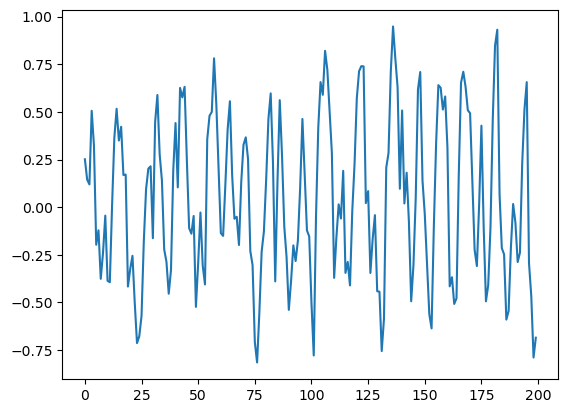

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3461b09120>

In [22]:
PyPlot.plot(fit_results["2021-10-26-01"]["θh"][1:200])